# Nudge LLM Trajectories via Emotional Axes

_See `notebooks/llm emotional control.pdf` for less abstract treatment._

In this notebook we will demonstrate control over probabilities assigned to 
trajectories $t_i^+, t_i^-$ for $i\in[N]$ from $t_i^+ \sim P_{LM}(t_i^+ | x_0^+)$ 
and $t_i^- \sim P_{LM}(t_i^- | x_0^-)$ i.i.d. 

**Experiment 1**: cache `key_value_plus`, `key_value_minus` from
*`model(x_0_plus)`, `model(x_0_minus)` 
k

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# gpt-2 model 
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

In [2]:
# Load the gpt-2 model 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to('cuda')

## 1: Compute `past_kv_plus`, `past_kv_minus`

In [3]:
# define dataset 
x_0_plus = "Alice was happy, so she"
x_0_minus = "Alice was sad, so she"

# tokenize as pytorch tensors 
x_0_plus_ids = tokenizer.encode(x_0_plus, return_tensors='pt').to('cuda')
x_0_minus_ids = tokenizer.encode(x_0_minus, return_tensors='pt').to('cuda')
print("x_0_plus_ids: ", x_0_plus_ids)
print("x_0_minus_ids: ", x_0_minus_ids)

# ensure tokenizer can decode
print("x_0_plus: ", tokenizer.decode(x_0_plus_ids[0]))
print("x_0_minus: ", tokenizer.decode(x_0_minus_ids[0]))

# retrieve past_kv_plus and past_kv_minus 
with torch.no_grad():
    outputs = model(x_0_plus_ids, past_key_values=None)
    past_kv_plus = outputs.past_key_values
    outputs = model(x_0_minus_ids, past_key_values=None)
    past_kv_minus = outputs.past_key_values

x_0_plus_ids:  tensor([[44484,   373,  3772,    11,   523,   673]], device='cuda:0')
x_0_minus_ids:  tensor([[44484,   373,  6507,    11,   523,   673]], device='cuda:0')
x_0_plus:  Alice was happy, so she
x_0_minus:  Alice was sad, so she


In [4]:
# let's go through one token at a time: 
for i in range(x_0_plus_ids.shape[1]): 
    print(f"Decoded {x_0_plus_ids[0, i]}: `{tokenizer.decode(x_0_plus_ids[0, i])}`")

Decoded 44484: `Alice`
Decoded 373: ` was`
Decoded 3772: ` happy`
Decoded 11: `,`
Decoded 523: ` so`
Decoded 673: ` she`


 - `past_kv_plus`, `past_kv_minus` are tuples of length `num_layer=12`. 
 - `past_kv[l]` is a tuple of length 2 (key, values) for layer `l`
 - `past_kv[l][0]` are the keys for layer `l`, shape `[b, num_heads, ]


In [5]:
print("0th layer, keys shape: ", past_kv_plus[0][0].shape) 
print(f"\tshape [batch, num_heads, seq_len, head_dim]")
print("0th layer, values shape: ", past_kv_plus[0][1].shape)
print(f"\tshape [batch, num_heads, seq_len, head_dim]")


0th layer, keys shape:  torch.Size([1, 12, 6, 64])
	shape [batch, num_heads, seq_len, head_dim]
0th layer, values shape:  torch.Size([1, 12, 6, 64])
	shape [batch, num_heads, seq_len, head_dim]


In [6]:
print("Number of heads in gpt2 attention: ", model.transformer.h[0].attn.num_heads)
print("Head dim in gpt2 attention: ", model.transformer.h[0].attn.head_dim)

Number of heads in gpt2 attention:  12
Head dim in gpt2 attention:  64


## 2: Sample trajectories $t_i^\pm \sim P_{LLM}(t_i^\pm | \text{past kv}^\pm)$

In [7]:
# Set the number of trajectories to sample
num_trajectories = 20
max_length = 50

In [10]:
# Function to sample a trajectory given the model, tokenizer, prompt, and past_kv
def sample_trajectory(model, tokenizer, past_kv, prompt_ids, max_length):
    """ Samples t ~ P_{LLM}(t | past_kv + prompt_ids)
    """
    # print("Prompt_ids shape: ", prompt_ids.shape)
    # print("Past kv shape value 0: ", past_kv[0][0].shape)

    num_past_toks = past_kv[0][0].shape[2]
    attention_mask = torch.ones([1, prompt_ids.shape[1] + num_past_toks]).to(model.device)
    # print("Attention mask shape: ", attention_mask.shape)

    with torch.no_grad():
        generated_ids = model.generate(
            prompt_ids,
            max_length=max_length,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_p=0.95,
            top_k=100,
            temperature=0.8,
            attention_mask=attention_mask,
            bad_words_ids=None,
            past_key_values=past_kv
        ).to('cuda')
    
    generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    return generated_text, generated_ids

In [12]:
# test the sample trajectory function 
prompt = " did"
prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

# t_plus_str is a string, t_plus_ids is a tensor of shape [1, traj_len], including the extra `prompt`
t_plus_str, t_plus_ids = sample_trajectory(model, tokenizer, past_kv_plus, prompt_ids, max_length)
print("[Trajectory plus: ]", t_plus_str)
print("\nNumber of tokens in trajectory: ", t_plus_ids.shape)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Trajectory plus: ]  did not mind, but he said that she must be careful.

The doctor told her that there was no way to tell her how she was feeling, so she kept silent.
....

Hearing that this new doctor

Number of tokens in trajectory:  torch.Size([1, 50])


In [17]:
# Sample trajectories for x_0_plus
prompt = " did"
prompt_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

trajectories_plus = []
for _ in tqdm(range(num_trajectories), desc="Sampling x_0_plus trajectories"):
    t_plus_str, t_plus_ids = sample_trajectory(model, tokenizer, past_kv_plus, prompt_ids, max_length)
    trajectories_plus.append({'str': t_plus_str, 'ids': t_plus_ids})

# Sample trajectories for x_0_minus
trajectories_minus = []
for _ in tqdm(range(num_trajectories), desc="Sampling x_0_minus trajectories"):
    t_minus_str, t_minus_ids = sample_trajectory(model, tokenizer, past_kv_minus, prompt_ids, max_length)
    trajectories_minus.append({'str': t_minus_str, 'ids': t_minus_ids})


Sampling x_0_minus trajectories: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


In [19]:
t_plus_lens = [t['ids'].shape[1] for t in trajectories_plus]
t_minus_lens = [t['ids'].shape[1] for t in trajectories_minus]

print(t_plus_lens)
print(t_minus_lens)

# keep only those trajectories that are = max_length
trajectories_plus = [t for t in trajectories_plus if t['ids'].shape[1] == max_length]
trajectories_minus = [t for t in trajectories_minus if t['ids'].shape[1] == max_length]

# ensure both are of the same length 
if len(trajectories_plus) > len(trajectories_minus):
    trajectories_plus = trajectories_plus[:len(trajectories_minus)]
else:
    trajectories_minus = trajectories_minus[:len(trajectories_plus)]

print("\nt_plus length: ", len(trajectories_plus))
print("t_minus length: ", len(trajectories_minus))

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
[50, 50, 35, 50, 50, 50, 49, 50, 50, 50, 50, 50, 46, 50, 50, 50, 50, 50, 50, 50]

t_plus length:  17
t_minus length:  17


In [20]:
# trajectories_plus[0]['str']

' did not feel sad.\n\n"Well, I am happy too," Yang said, smiling broadly at her partner. "But I am worried about you."\n\nHe nodded. "I know that. But you don\'t seem quite in that'

In [21]:
# past_kv_plus[0][0].shape

torch.Size([1, 12, 6, 64])

In [23]:
# trajectories_plus[0]['ids'].shape

torch.Size([1, 50])

## 2.5: Computing Trajectory $t_i^\pm$ Probabilities given $x_0^\pm$

In [24]:
# now let's compute the probability of each trajectory given each prompt 
def get_traj_prob(traj_ids, past_kv, model): 
    """ Computes the probability of a trajectory given the past_kv. 
    """
    num_kv_toks = past_kv[0][0].shape[2]
    num_traj_toks = traj_ids.shape[1]

    labels = traj_ids 
    attention_mask = torch.ones([1, num_kv_toks + num_traj_toks]).to(model.device)

    with torch.no_grad():
        outputs = model(traj_ids, past_key_values=past_kv, labels=labels, attention_mask=attention_mask)
        loss = outputs.loss
        log_prob = -loss
    
    return log_prob.item()

In [26]:
# test get_traj_prob function 
traj_prob = get_traj_prob(trajectories_minus[0]['ids'], past_kv_plus, model)
print("Trajectory log probability: ", traj_prob)

Trajectory log probability:  -2.1982598304748535


No we can compute the log probability of each trajectory given its corresponding 
past_kv +/-

In [32]:
# Compute log probabilities for x_0_plus trajectories
for trajectory in tqdm(trajectories_plus, desc="Computing log probs for x_0_plus trajectories"):
    log_prob = get_traj_prob(trajectory['ids'], past_kv_plus, model)
    trajectory['log_prob'] = log_prob

# Compute log probabilities for x_0_minus trajectories
for trajectory in tqdm(trajectories_minus, desc="Computing log probs for x_0_minus trajectories"):
    log_prob = get_traj_prob(trajectory['ids'], past_kv_minus, model)
    trajectory['log_prob'] = log_prob

# add a field (log_prob_other) for log P(t_plus | x_0_minus) and log P(t_minus | x_0_plus) 
for trajectory in tqdm(trajectories_plus, desc="Computing log probs for x_0_plus trajectories_minus"):
    log_prob_other = get_traj_prob(trajectory['ids'], past_kv_minus, model)
    trajectory['log_prob_given_other'] = log_prob_other

for trajectory in tqdm(trajectories_minus, desc="Computing log probs for x_0_minus trajectories_plus"):
    log_prob_other = get_traj_prob(trajectory['ids'], past_kv_plus, model)
    trajectory['log_prob_given_other'] = log_prob_other

Computing log probs for x_0_minus trajectories: 100%|██████████| 17/17 [00:00<00:00, 118.36it/s]
Computing log probs for x_0_plus trajectories_minus: 100%|██████████| 17/17 [00:00<00:00, 123.28it/s]
Computing log probs for x_0_minus trajectories_plus: 100%|██████████| 17/17 [00:00<00:00, 123.55it/s]


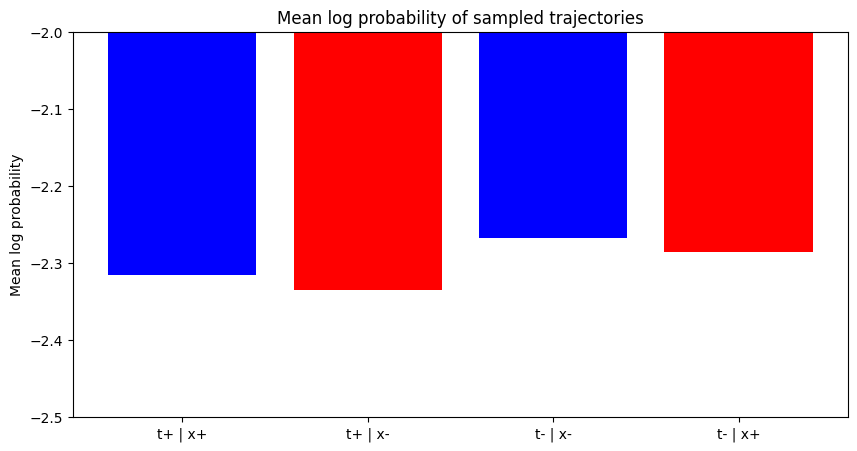

In [35]:
mean_log_prob_plus = np.mean([t['log_prob'] for t in trajectories_plus])
mean_log_prob_minus = np.mean([t['log_prob'] for t in trajectories_minus])

mean_log_prob_plus_given_other = np.mean([t['log_prob_given_other'] for t in trajectories_plus])
mean_log_prob_minus_given_other = np.mean([t['log_prob_given_other'] for t in trajectories_minus])

# bar chart 
plt.figure(figsize=(10, 5))
plt.bar(['t+ | x+', 't+ | x-', 't- | x-', 't- | x+'], [mean_log_prob_plus, mean_log_prob_plus_given_other, mean_log_prob_minus, mean_log_prob_minus_given_other], color=['blue', 'red', 'blue', 'red'])
# colors 
# adjust y axis range
plt.ylim([-2.5, -2.0])
plt.ylabel('Mean log probability')
plt.title('Mean log probability of sampled trajectories')
plt.show()


## 3: Generating $\text{past kv}^\lambda$

In [48]:
# generate a bunch of lambda values between 0 and 1 (np linspace or something)
lambdas = np.linspace(0, 1, 25)

# function to create past_kv_lambda = (1-lambda) past_kv_min + lambda past_kv_plus
# recall that past_kv are tuples of length 12 (12 layers)
# each past_kv[i] is a tuple of length 2 (key, value)
# each key, value is a tensor of shape [1, num_heads, seq_len, head_dim]

# Function to create past_kv_lambda
def create_past_kv_lambda(past_kv_plus, past_kv_minus, lambda_val):
    past_kv_lambda = []
    for layer_past_kv_plus, layer_past_kv_minus in zip(past_kv_plus, past_kv_minus):
        layer_past_kv_lambda = []
        for key_plus, value_plus, key_minus, value_minus in zip(layer_past_kv_plus[0], layer_past_kv_plus[1], layer_past_kv_minus[0], layer_past_kv_minus[1]):
            key_lambda = (1 - lambda_val) * key_minus + lambda_val * key_plus
            value_lambda = (1 - lambda_val) * value_minus + lambda_val * value_plus
            # add a leading batch dimension to both 
            key_lambda = key_lambda.unsqueeze(0)
            value_lambda = value_lambda.unsqueeze(0)
            layer_past_kv_lambda.append((key_lambda, value_lambda))
        past_kv_lambda.append(tuple(*layer_past_kv_lambda))
    return tuple(past_kv_lambda)

# Test the create_past_kv_lambda function
lambda_val = 0.5
past_kv_lambda = create_past_kv_lambda(past_kv_plus, past_kv_minus, lambda_val)
print(f"Length of past_kv_lambda: {len(past_kv_lambda)}")
print(f"Shape of past_kv_lambda[0][0]: {past_kv_lambda[0][0].shape}")
print(f"Shape of past_kv_lambda[0][1]: {past_kv_lambda[0][1].shape}")

Length of past_kv_lambda: 12
Shape of past_kv_lambda[0][0]: torch.Size([1, 12, 6, 64])
Shape of past_kv_lambda[0][1]: torch.Size([1, 12, 6, 64])


In [49]:
past_kv_plus[0][0].shape

torch.Size([1, 12, 6, 64])

## 4: $P(t_i^\pm | \text{past kv}^\lambda)$ for $\lambda = 0, \dots, 1$

In [51]:
# Compute log probabilities for each trajectory and each lambda value
for lambda_val in tqdm(lambdas, desc="Computing log probs for lambdas"):
    past_kv_lambda = create_past_kv_lambda(past_kv_plus, past_kv_minus, lambda_val)
    
    for trajectory in trajectories_plus:
        log_prob = get_traj_prob(trajectory['ids'], past_kv_lambda, model)
        if 'log_probs' not in trajectory:
            trajectory['log_probs'] = {}
        trajectory['log_probs'][lambda_val] = log_prob
    
    for trajectory in trajectories_minus:
        log_prob = get_traj_prob(trajectory['ids'], past_kv_lambda, model)
        if 'log_probs' not in trajectory:
            trajectory['log_probs'] = {}
        trajectory['log_probs'][lambda_val] = log_prob

# Print the log probabilities for each trajectory and each lambda value
# print("Log probabilities for x_0_plus trajectories:")
# for i, trajectory in enumerate(trajectories_plus, 1):
#     print(f"Trajectory {i}: {trajectory['str']}")
#     for lambda_val, log_prob in trajectory['log_probs'].items():
#         print(f"  Lambda {lambda_val:.2f}: {log_prob:.4f}")
#     print()

# print("\nLog probabilities for x_0_minus trajectories:")
# for i, trajectory in enumerate(trajectories_minus, 1):
#     print(f"Trajectory {i}: {trajectory['str']}")
#     for lambda_val, log_prob in trajectory['log_probs'].items():
#         print(f"  Lambda {lambda_val:.2f}: {log_prob:.4f}")
#     print()

Computing log probs for lambdas: 100%|██████████| 25/25 [00:06<00:00,  3.68it/s]


In [53]:
# lambdas

array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])

In [56]:
# trajectory['log_probs'][lambdas[1]]

-2.3727004528045654

In [54]:
# trajectory['log_probs']

{0.0: -2.374145984649658,
 0.041666666666666664: -2.3727004528045654,
 0.08333333333333333: -2.3713107109069824,
 0.125: -2.369981527328491,
 0.16666666666666666: -2.3687045574188232,
 0.20833333333333331: -2.3674776554107666,
 0.25: -2.3662941455841064,
 0.29166666666666663: -2.3651533126831055,
 0.3333333333333333: -2.3640542030334473,
 0.375: -2.362987518310547,
 0.41666666666666663: -2.361957311630249,
 0.4583333333333333: -2.360959768295288,
 0.5: -2.3599953651428223,
 0.5416666666666666: -2.359060525894165,
 0.5833333333333333: -2.358154535293579,
 0.625: -2.3572771549224854,
 0.6666666666666666: -2.356431245803833,
 0.7083333333333333: -2.355611562728882,
 0.75: -2.3548200130462646,
 0.7916666666666666: -2.354059934616089,
 0.8333333333333333: -2.353323221206665,
 0.875: -2.3526172637939453,
 0.9166666666666666: -2.351938009262085,
 0.9583333333333333: -2.351285219192505,
 1.0: -2.350661516189575}

In [58]:
# sum(log_probs_plus) / len(log_probs_plus)

-2.316040277481079

In [59]:
# mean_log_probs_plus

{0.0: -2.3353031663333668,
 0.041666666666666664: -2.33373986973482,
 0.08333333333333333: -2.332251226200777,
 0.125: -2.3308301112231087,
 0.16666666666666666: -2.329474925994873,
 0.20833333333333331: -2.328178321613985,
 0.25: -2.326938573051901,
 0.29166666666666663: -2.325752061956069,
 0.3333333333333333: -2.324620246887207,
 0.375: -2.323548611472635,
 0.41666666666666663: -2.322548501631793,
 0.4583333333333333: -2.321636704837575,
 0.5: -2.3208308500402115,
 0.5416666666666666: -2.3201165199279785,
 0.5833333333333333: -2.3194627481348373,
 0.625: -2.3188669821795296,
 0.6666666666666666: -2.3183391094207764,
 0.7083333333333333: -2.3178720894981835,
 0.75: -2.317463383955114,
 0.7916666666666666: -2.3171079299029183,
 0.8333333333333333: -2.3168037077959847,
 0.875: -2.316546874887803,
 0.9166666666666666: -2.316334429909201,
 0.9583333333333333: -2.316165896023021,
 1.0: -2.316040277481079}

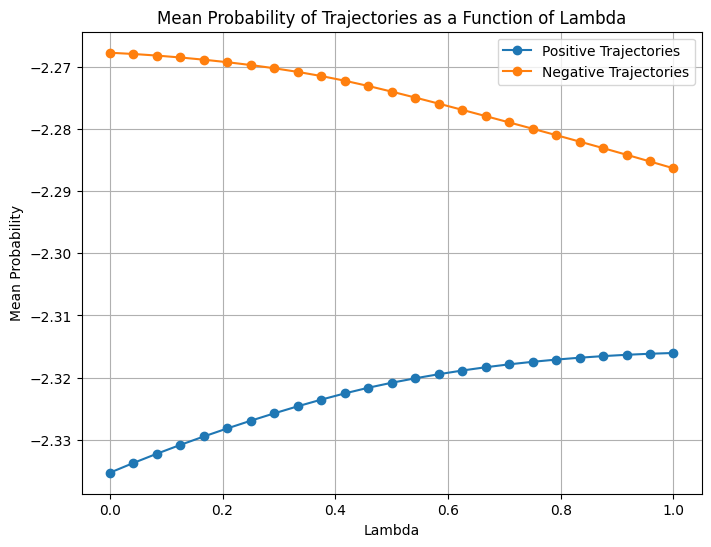

In [60]:
import matplotlib.pyplot as plt

# Compute the mean log probabilities for each lambda value
mean_log_probs_plus = {}
mean_log_probs_minus = {}

for lambda_val in lambdas:
    log_probs_plus = [trajectory['log_probs'][lambda_val] for trajectory in trajectories_plus]
    log_probs_minus = [trajectory['log_probs'][lambda_val] for trajectory in trajectories_minus]
    
    mean_log_probs_plus[lambda_val] = sum(log_probs_plus) / len(log_probs_plus)
    mean_log_probs_minus[lambda_val] = sum(log_probs_minus) / len(log_probs_minus)

# Convert the mean log probabilities to mean probabilities
# mean_probs_plus = {lambda_val: np.exp(log_prob) for lambda_val, log_prob in mean_log_probs_plus.items()}
# mean_probs_minus = {lambda_val: np.exp(log_prob) for lambda_val, log_prob in mean_log_probs_minus.items()}

# keep mean log probabilities as log probabilities
mean_probs_plus = {lambda_val: log_prob for lambda_val, log_prob in mean_log_probs_plus.items()}
mean_probs_minus = {lambda_val: log_prob for lambda_val, log_prob in mean_log_probs_minus.items()}

# Plot the mean probabilities as a function of lambda
plt.figure(figsize=(8, 6))
plt.plot(list(mean_probs_plus.keys()), list(mean_probs_plus.values()), marker='o', label='Positive Trajectories')
plt.plot(list(mean_probs_minus.keys()), list(mean_probs_minus.values()), marker='o', label='Negative Trajectories')
plt.xlabel('Lambda')
plt.ylabel('Mean Probability')
plt.title('Mean Probability of Trajectories as a Function of Lambda')
plt.legend()
plt.grid(True)
plt.show()

where $\lambda = 1$ corresponds to $\text{past kv}^+$, and conversely $\lambda = 0 \to  \text{past kv}^-$, 

## 